## Members
- Cao Thanh Khiết   19120544
- Ninh Duy Huy      19120533
- Lê Minh Hữu       19120525
- Nguyễn Tuấn Khoa  19120547
- Trần Tuấn Kiệt    19120557

# Pre-processing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


from vncorenlp import VnCoreNLP

In [2]:
vncorenlp_file = "VnCoreNLP/VnCoreNLP-1.1.1.jar"

In [3]:
data_df = pd.read_csv("vfnd/CSV/vn_news_223_tdlfr.csv")
data_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


##### List of vietnamese stopwords

In [5]:
vn_stopwords = []
with open('data/vietnamese_stopwords.txt', encoding="utf8") as file:
    for line in file.read().splitlines():
        vn_stopwords.append(line.strip())

## EDA (Exploratory Data analysis)

##### Dữ liệu có bị lặp không

In [6]:
data_df.index.duplicated().sum()

0

##### Dữ liệu có null hay không

In [7]:
data_df.isnull().sum()

text      0
domain    0
label     0
dtype: int64

##### Sự phân bố các lớp label có lệch nhau không

0    55.156951
1    44.843049
Name: label, dtype: float64

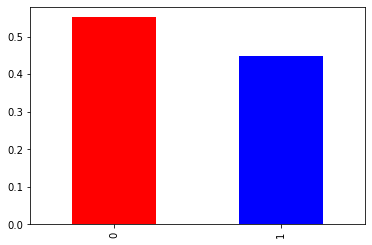

In [8]:
data_df.label.value_counts(normalize=True).plot(kind="bar", color=["red", "blue"])
data_df['label'].value_counts(normalize=True) * 100

--> Sự phân bố giữa 2 lớp khá tương đương nhau, không lệch nhau nhiều

##### Chiều dài trung bình các record

In [9]:
len_record = []
text_series = data_df['text']
for text in text_series:
    len_record.append(len(text))
len_record = pd.Series(len_record)
round(len_record.sum() / len(len_record), 2)

2539.77

In [10]:
'''
We will extract X_train and Y_train, X_train will contains only column "text", Y_train contains column "label"
'''
X_df = data_df.iloc[:, :-2].values
Y_target = data_df.iloc[:, -1].values

### Loại bỏ một số giá trị không cần thiết
- Loại bỏ stopwords
- Tokenize đoạn văn thành những từ có nghĩa

In [11]:
def preprocessing(X_df):

    for index, test_str in enumerate(X_df):
        # Remove http links
        filtered_str = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", test_str[0])
        # Remove all number in string
        filtered_str = ''.join([i for i in filtered_str if not i.isdigit()])
        # Remove all special characters and punctuation
        filtered_str = re.sub('\W+',' ', filtered_str)
        filtered_str = filtered_str.strip()
        X_df[index][0] = filtered_str.lower()

    X_df = X_df.flatten()


    # Remove stop words
    for index, test_str in enumerate(X_df):
        sw_removed = [w for w in test_str.split(' ') if not w in vn_stopwords]
        X_df[index] = ' '.join(sw_removed)

    return X_df

# Tokenize the sentences into words
def tokennize_text(X_df):
    '''
    return a numpy array of preprocessed text, each item in array is a paragraph after remove stopwords, special characters, ...
    '''
    # annotator = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')
    annotator = VnCoreNLP(vncorenlp_file)
    with annotator:
        for index, filtered_text in enumerate(X_df):
            token_text = annotator.tokenize(filtered_text)[0]
            X_df[index] = ' '.join(token_text)
    
    return X_df

In [12]:
'''
Now, apply preprocessing into my text
'''
X_df = preprocessing(X_df)
X_df = tokennize_text(X_df)

In [13]:
''' Extracting feature from text data
We use Bag of words model for converting text to numerical data
Now, we create a Document Term Matrix (Bag of Words), we will vectorize the normal text
'''
# Use CountVectorizer to convert text data into numerical values
def create_DTM(X_df):
    cv = CountVectorizer(analyzer='word')
    data = cv.fit_transform(X_df).todense()
    return data


'''TF-IDF'''
def vectorize_tfidf(X_df):
    vectorization = TfidfVectorizer()
    return vectorization.fit_transform(X_df).todense()

# vectorization = TfidfVectorizer()
# xv_train = vectorization.fit_transform(X_df).todense()

## Build Model

In [14]:
'''Split data into train-test set'''
X_train_vect, X_test_vect, y_train, y_test = train_test_split(X_df, Y_target, test_size=0.2, random_state=0)

'''Fit and transform model'''
vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train_vect)
X_test = vectorization.transform(X_test_vect)

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
acc_test = round(LR.score(X_test, y_test)*100, 2)
print(f"Accuracy on test set: {acc_test}%")

Accuracy on test set: 86.67%


In [17]:
pred_LR = LR.predict(X_test)
pred_LR

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0], dtype=int64)

In [18]:
cfs_mat = confusion_matrix(y_test, pred_LR)
cfs_mat

array([[25,  2],
       [ 4, 14]], dtype=int64)

### Decision Tree

In [19]:
'''
Build model and predict in test dataset
'''
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0], dtype=int64)

In [20]:
cfs_mat = confusion_matrix(y_test, y_pred)
cfs_mat

array([[23,  4],
       [ 7, 11]], dtype=int64)

In [21]:
# accuracy = round((cfs_mat[0][0] + cfs_mat[1][1]) / (cfs_mat[0][0] + cfs_mat[0][1] + cfs_mat[1][0] + cfs_mat[1][1])*100, 2)
acc_test = round(dtc.score(X_test, y_test)*100, 2)
print(f"Accuracy on test set: {acc_test}%")

Accuracy on test set: 77.78%


### Gradient Booting Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [23]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)
GBC_accur = round(GBC.score(X_test, y_test)*100, 2)
print(f"Accuracy on test set: {GBC_accur}%")

Accuracy on test set: 75.56%


In [24]:
pred_GBC = GBC.predict(X_test)
pred_GBC

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [25]:
cfs_mat = confusion_matrix(y_test, pred_GBC)
cfs_mat

array([[24,  3],
       [ 8, 10]], dtype=int64)

### LinearRegession

In [26]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
REG = linear_model.LinearRegression()
REG.fit(X_train, y_train)
y_pred = REG.predict(X_test)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
REG_accur = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy on test set: {REG_accur}%")

Accuracy on test set: 86.67%


### Nearest Centroid Classifier

In [27]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(X_train, y_train)
NC_pred = clf.predict(X_test)
NC_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0], dtype=int64)

In [28]:
cfs_mat = confusion_matrix(y_test, NC_pred)
cfs_mat

array([[24,  3],
       [ 2, 16]], dtype=int64)

In [29]:
NC_accur = round(clf.score(X_test, y_test)*100, 2)
print(f"Accuracy on test set: {NC_accur}%")

Accuracy on test set: 88.89%


#### Manual testing

In [33]:
def print_result(predict, name):
    print(f"{name} predicts: ", end='')
    if predict[0] == 0:
        print("Fake news")
    else:
        print("is not Fake")

def manual_testing(news):
# news = "cao thanh khiết víp pro hahaaha cuộc sống này thật tươi đẹp, quang hải đã giành chức vô địch ở giải thế giới"

    test_dict = {"text": [news]}
    test_df = pd.DataFrame(test_dict)

    text = test_df.iloc[:,:].values

    processed_text = tokennize_text(preprocessing(text))

    vector_text = vectorization.transform(processed_text)

    return LR.predict(vector_text), dtc.predict(vector_text), GBC.predict(vector_text), clf.predict(vector_text)

In [34]:
news = "Tại buổi họp báo, ông Huỳnh Thuận, phó giám đốc Sở Y tế Quảng Nam, cho biết ngành y tế không mua kit test xét nghiệm Covid-19 của Công ty Việt Á. Trước năm 2021, có mượn máy xét nghiệm của công ty này để sử dụng và đến đầu năm 2021 đã trả lại. Phát biểu kết luận, Phó chủ tịch UBND tỉnh Quảng Nam Trần Văn Tân cho biết về việc tỉnh Quảng Nam mượn máy xét nghiệm của Công ty Việt Á thì tỉnh đã chủ động cung cấp thông tin cho báo chí.Theo ông Tân, năm 2021 tỉnh không mua kit test xét nghiệm Covid-19 của Công ty Việt Á mà chỉ mượn máy xét nghiệm xong rồi trả."

lr_pred, dtc_pred, gbc_pred, ncc_pred = manual_testing(news)
print_result(lr_pred, "Logistic_Regression ")
print_result(dtc_pred, "Decision_Tree ")
print_result(gbc_pred, "Gradient_Booting_Classifier ")
print_result(ncc_pred, "Nearest_Centroid_Classifier ")

Logistic_Regression  predicts: Fake news
Decision_Tree  predicts: is not Fake
Gradient_Booting_Classifier  predicts: Fake news
Nearest_Centroid_Classifier  predicts: Fake news


### Deploy